In [6]:
import os
import json
import pickle
import time
import numpy as np
import faiss
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
%run 02_interactive.ipynb
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Loaded 38 documents from corpus


In [7]:
with open("test_dataset.json", "r") as f:
    test_cases = json.load(f)

In [8]:
results = []

print(f"Evaluating {len(test_cases)} test cases across 4 systems...")

for i, case in enumerate(tqdm(test_cases)):
    code = case['student_code']
    true_label = case['label'] 
    
    pred_1 = detect_embedding(code)

    pred_2 = detect_llm(code)
    
    pred_3 = detect_rag(code)

    pred_4 = detect_hybrid_rag(code)
    
    results.append({
        "id": case['id'],
        "truth": true_label,
        "pred_sys1": pred_1['verdict'],
        "pred_sys2": pred_2['verdict'],
        "pred_sys3": pred_3['verdict'],
        "pred_sys4": pred_4['verdict'],
    })

Evaluating 30 test cases across 4 systems...


100%|██████████| 30/30 [01:44<00:00,  3.48s/it]


In [9]:
df = pd.DataFrame(results)

def calculate_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
    }

metrics = []


# System 1
m1 = calculate_metrics(df['truth'], df['pred_sys1'])
m1['System'] = "Pure Embedding"
metrics.append(m1)

# # System 2
m2 = calculate_metrics(df['truth'], df['pred_sys2'])
m2['System'] = "Direct LLM"
metrics.append(m2)

# # System 3
m3 = calculate_metrics(df['truth'], df['pred_sys3'])
m3['System'] = "Standard RAG"
metrics.append(m3)

# # System 4
m4 = calculate_metrics(df['truth'], df['pred_sys4'])
m4['System'] = "Hybrid RAG"
metrics.append(m4)


final_df = pd.DataFrame(metrics).set_index("System")


<Figure size 1200x600 with 0 Axes>

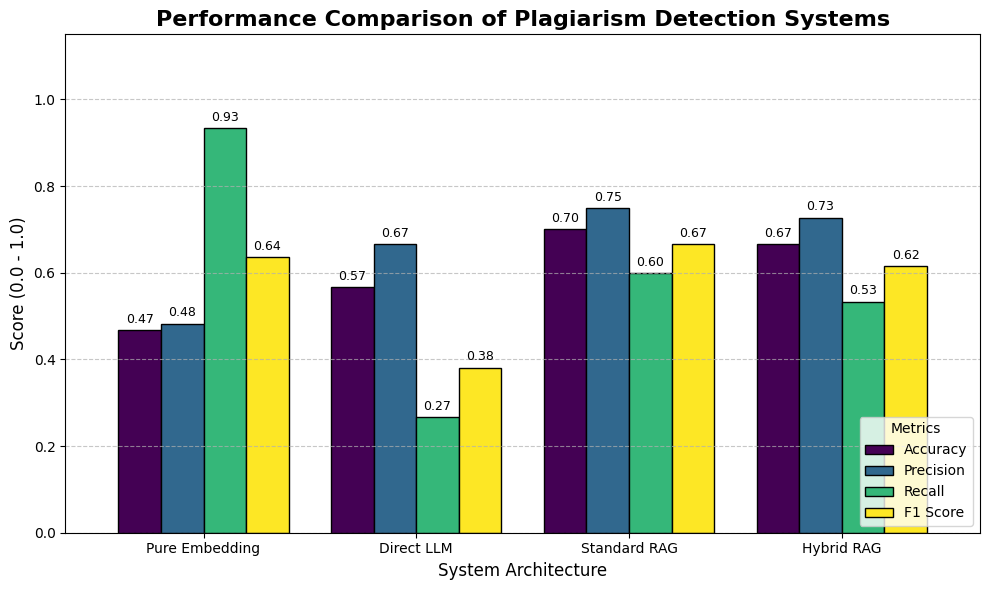

In [10]:
plt.figure(figsize=(12, 6))

ax = final_df.plot(kind='bar', figsize=(10, 6), width=0.8, colormap="viridis", edgecolor="black")

plt.title("Performance Comparison of Plagiarism Detection Systems", fontsize=16, fontweight='bold')
plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
plt.xlabel("System Architecture", fontsize=12)
plt.ylim(0, 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc='lower right', title="Metrics")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig("system_comparison_graph.png", dpi=300)
plt.show()